In [94]:
import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier as kNearestNeighbors
from sklearn.linear_model import LogisticRegression
# import lightgbm as lgb
from sklearn import svm 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

In [7]:
import numpy as np
import pandas as pd
train_data = pd.read_csv('candidate_train.csv')
test_data = pd.read_csv('candidate_val.csv')
label = pd.read_csv('train_answer.csv')
print(train_data.shape)
print(test_data.shape)
print(label.shape)

(79267, 3178)
(26358, 3178)
(79267, 7)


### 1. 按照ID排序

In [6]:
train_data.head()

,0,1,2,3,4,5,6,7,8,9,...,3168,3169,3170,3171,3172,3173,3174,3175,3176,id
0,0,0,0,0,0,0,0,0,4,0,...,639.301885,674.304907,2.427349,129.159,-0.8904,3,2,51.40,2,c8834c14
1,0,0,0,0,0,0,0,0,2,0,...,253.707942,345.257130,1.801976,124.143,-1.3584,3,2,60.95,0,c4758613
2,0,0,0,0,0,0,0,0,1,1,...,389.501935,427.557546,1.989185,121.139,-0.8106,2,1,23.24,0,8e4b1d9a
3,0,0,0,0,0,0,1,0,2,0,...,264.569528,398.755261,1.921451,126.155,0.3463,2,1,37.30,0,ab4ec102
4,0,0,0,0,0,0,0,0,1,0,...,472.605173,552.977010,2.132529,127.099,-0.1910,4,1,55.40,1,dd1317ea


In [12]:
Train = pd.merge(train_data,label,on='id')

In [14]:
label.head()

,id,p1,p2,p3,p4,p5,p6
0,45ec2bbe,1.6866,-0.2340,0.0777,0.184867,-387.077548,-387.069843
1,530775c3,1.2997,-0.2518,0.0232,0.170199,-440.300227,-440.290746
2,4ca38b2c,3.6442,-0.2436,-0.0062,0.137677,-380.868636,-380.860872
3,630fe593,6.7048,-0.2374,0.0374,0.172693,-440.302592,-440.293710
4,b4812aaf,1.4201,-0.1824,0.0389,0.135641,-455.179317,-455.169936


In [15]:
label[label['id'].isin(['c8834c14'])]

,id,p1,p2,p3,p4,p5,p6
18990,c8834c14,1.1804,-0.2437,0.0576,0.170321,-440.223611,-440.214222


In [13]:
Train.head()

,0,1,2,3,4,5,6,7,8,9,...,3174,3175,3176,id,p1,p2,p3,p4,p5,p6
0,0,0,0,0,0,0,0,0,4,0,...,2,51.40,2,c8834c14,1.1804,-0.2437,0.0576,0.170321,-440.223611,-440.214222
1,0,0,0,0,0,0,0,0,2,0,...,2,60.95,0,c4758613,3.1103,-0.2424,-0.0294,0.138296,-417.984094,-417.976838
2,0,0,0,0,0,0,0,0,1,1,...,1,23.24,0,8e4b1d9a,1.2346,-0.2479,0.0159,0.123959,-400.647248,-400.639696
3,0,0,0,0,0,0,1,0,2,0,...,1,37.30,0,ab4ec102,3.2361,-0.2341,-0.0176,0.157146,-423.022821,-423.013580
4,0,0,0,0,0,0,0,0,1,0,...,1,55.40,1,dd1317ea,3.8822,-0.2524,-0.0655,0.102003,-473.888949,-473.881271


In [25]:
test_data.head()

,0,1,2,3,4,5,6,7,8,9,...,3168,3169,3170,3171,3172,3173,3174,3175,3176,id
0,0,0,0,0,0,0,1,0,0,0,...,266.664496,344.876756,1.786485,112.092,-1.42970,5,0,60.67,0,66b19220
1,0,0,0,0,0,0,0,0,3,0,...,423.242443,435.415219,2.029533,123.155,0.59510,2,1,29.10,0,bed4af38
2,0,0,0,0,0,0,1,0,1,0,...,240.376174,346.247541,1.829334,113.120,-0.39458,4,2,61.80,1,96f5658c
3,0,0,0,0,0,0,3,0,1,0,...,438.281302,513.076246,2.230665,118.176,0.79220,2,1,29.46,3,d7031639
4,0,0,0,0,0,0,1,0,5,0,...,333.248296,473.313759,2.143609,123.199,2.48038,1,0,23.79,2,1fdd8f3c


### 2. 分割数据

In [208]:
X_train = Train.iloc[:,:3178]
y_train = Train.iloc[:,3178:3184]
X_test = test_data.iloc[:,:3177]

##### 数据分桶, 找最好的 seed 使得 l 最小

In [155]:
def kl_div(dis1, dis2):
    assert (len(dis1) == len(dis2))
    dis1 = np.array(dis1) + 1e-8
    dis2 = np.array(dis2) + 1e-8
    kl = 0
    for i in range(len(dis1)):
        kl += dis1[i] * np.log(dis1[i] / dis2[i])
    return kl


def js_div(dis1, dis2):
    assert (len(dis1) == len(dis2))
    dis1 = np.array(dis1)
    dis2 = np.array(dis2)
    mid = (dis1 + dis2) / 2
    return 0.5 * kl_div(dis1, mid) + 0.5 * kl_div(dis2, mid)
# print(kl_div([0.2, 0.2, 0.2, 0.2, 0.2], [0.1, 0.1, 0.1, 0.1, 0.6]))
# print(js_div(np.array([0.2, 0.2, 0.2, 0.2, 0.2]), np.array([0.2, 0.2, 0.2, 0.2, 0.2])))

In [173]:
col = 2
bucket_num = 500

y = list(y_train.iloc[:, col].values)
y_max = max(y)
y_min = min(y)
leap = (y_max - y_min) / bucket_num
bucket = [0] * bucket_num
for value in y:
    if value >= y_max - leap:
        bucket[-1] += 1
    else:
        bucket[int((value - y_min) / leap)] += 1
freq_1 = [x / len(y) for x in bucket]
print(sum(freq_1))
assert np.isclose(sum(freq_1), 1)

1.0


In [174]:
for seed in range(1000):
    train_x, valid_x, train_y, valid_y = train_test_split(X_train, y_train, test_size=0.3, random_state=seed)

#     print(y_train.shape)
#     print(train_y.shape)
#     print(valid_y.shape)

    y = list(train_y.iloc[:, col].values)
    bucket = [0] * bucket_num
    for value in y:
        if value >= y_max - leap:
            bucket[-1] += 1
        else:
            bucket[int((value - y_min) / leap)] += 1
    freq_2 = [x / len(y) for x in bucket]
    assert np.isclose(sum(freq_2), 1)

    y = list(valid_y.iloc[:, col].values)
    bucket = [0] * bucket_num
    for value in y:
        if value >= y_max - leap:
            bucket[-1] += 1
        else:
            bucket[int((value - y_min) / leap)] += 1
    freq_3 = [x / len(y) for x in bucket]
    assert np.isclose(sum(freq_3), 1)

    # %%

    l1 = kl_div(freq_1, freq_2)
    l2 = kl_div(freq_1, freq_3)
    l3 = kl_div(freq_2, freq_2)
    l = (l1 + l2 + l3) / 3
#     print(l)
#     dic[seed] = l

seed_and_l = sorted(dic.items(), key=lambda x: x[1])
print(seed_and_l)

[(9, 0.0033846275732877713), (17, 0.0036778135696648815), (16, 0.0038092518616659223), (15, 0.0038355079314329014), (3, 0.0038616627169566005), (14, 0.003982617007009913), (1, 0.004043412093812935), (5, 0.004089464205353485), (18, 0.004110743630052671), (13, 0.004204149391459202), (12, 0.004232932075211218), (10, 0.004475886523290202), (4, 0.004541617954823991), (11, 0.004627245718295017), (19, 0.004631801938691425), (8, 0.004692893003728605), (2, 0.004710267222614154), (7, 0.004717891451952714), (0, 0.005318055966992081), (6, 0.005636008967082381)]


##### seed为 9，保存csv

In [253]:
#去掉只含一个列的
# 去掉只有一个值的列
One_value_array = []
for i in range(3177):
    if len(X_train.iloc[:, i].value_counts()) == 1:
        One_value_array.append(str(i))

In [254]:
X_train = X_train.drop(columns=One_value_array)
X_test = X_test.drop(columns=One_value_array)

In [256]:
train_x, valid_x, train_y, valid_y = train_test_split(X_train, y_train, test_size=0.3, random_state=9)

In [258]:
train_x.shape

(55486, 3127)

In [259]:
train_x.head()

,6,7,8,9,10,11,12,13,14,15,...,3168,3169,3170,3171,3172,3173,3174,3175,3176,id
50930,1,0,3,0,0,0,2,0,0,0,...,480.904200,489.831830,2.178047,126.199,1.5574,1,1,20.23,1,523d0b69
5501,1,0,0,0,1,0,0,0,0,2,...,376.834975,491.797349,2.023857,126.119,-0.8068,5,2,71.52,1,bbe3e682
10621,1,0,2,0,0,0,0,0,0,1,...,478.021836,526.940716,2.135921,128.135,-1.3335,5,1,64.03,2,642bdad9
22695,1,0,1,0,0,0,5,0,0,0,...,137.296661,154.401003,1.474635,94.157,1.5182,0,0,0.00,0,386a9891
3329,1,0,3,0,0,0,1,0,0,0,...,269.828422,309.270217,1.768070,126.155,0.5642,2,0,21.76,0,3f1e4fdc


In [261]:
col_name = train_x.columns.tolist()
del col_name[-1]
col_name.insert(col_name.index('6'),'id')# 在 6 列前面插入
train_x = train_x.reindex(columns=col_name)

In [262]:
col_name = valid_x.columns.tolist()
del col_name[-1]
col_name.insert(col_name.index('6'),'id')# 在 6 列前面插入
valid_x = valid_x.reindex(columns=col_name)

In [265]:
train_x.to_csv("train_feature.csv")
valid_x.to_csv("valid_feature.csv")
train_y.to_csv("train_label.csv")
valid_y.to_csv("valid_label.csv")
X_test.to_csv("test_feature.csv")

##### 数据读取 (P3)

In [266]:
train_x = pd.read_csv('train_feature.csv')
train_x = train_x.drop(columns='Unnamed: 0')
train_y = pd.read_csv('train_label.csv')
train_y = train_y['p3']

In [267]:
valid_x = pd.read_csv('valid_feature.csv')
valid_x = valid_x.drop(columns='Unnamed: 0')
valid_y = pd.read_csv('valid_label.csv')
valid_y = valid_y['p3']

In [268]:
test_x = pd.read_csv('test_feature.csv')
test_x = test_x.drop(columns='Unnamed: 0')

In [269]:
train_x.head()

,id,6,7,8,9,10,11,12,13,14,...,3167,3168,3169,3170,3171,3172,3173,3174,3175,3176
0,523d0b69,1,0,3,0,0,0,2,0,0,...,92.720506,480.904200,489.831830,2.178047,126.199,1.5574,1,1,20.23,1
1,bbe3e682,1,0,0,0,1,0,0,0,0,...,114.988293,376.834975,491.797349,2.023857,126.119,-0.8068,5,2,71.52,1
2,642bdad9,1,0,2,0,0,0,0,0,0,...,90.603808,478.021836,526.940716,2.135921,128.135,-1.3335,5,1,64.03,2
3,386a9891,1,0,1,0,0,0,5,0,0,...,73.961527,137.296661,154.401003,1.474635,94.157,1.5182,0,0,0.00,0
4,3f1e4fdc,1,0,3,0,0,0,1,0,0,...,146.618553,269.828422,309.270217,1.768070,126.155,0.5642,2,0,21.76,0


In [270]:
valid_x.head()

,id,6,7,8,9,10,11,12,13,14,...,3167,3168,3169,3170,3171,3172,3173,3174,3175,3176
0,a47f439f,1,0,2,0,0,0,2,0,0,...,190.215460,237.494497,298.283668,1.738789,130.143,-0.25990,3,1,38.69,0
1,39485253,1,0,1,0,0,0,0,0,3,...,27.748737,294.507882,322.256619,2.085947,79.102,0.92338,1,0,23.79,0
2,d2481dfe,1,0,2,0,2,0,3,0,0,...,128.301479,240.803156,271.556239,1.721426,120.195,2.21850,0,0,0.00,0
3,14c33f4a,1,0,1,0,2,0,3,0,0,...,161.176332,323.220006,425.529115,1.979787,128.171,0.30420,2,2,40.46,0
4,57d99567,2,0,1,0,0,0,1,0,2,...,48.766444,383.935888,422.760347,2.203859,98.145,0.78060,1,1,20.23,1


In [271]:
train_y.head()

0    0.0754
1   -0.0533
2   -0.0262
3    0.0989
4    0.0590
Name: p3, dtype: float64

In [272]:
test_x.head()

,6,7,8,9,10,11,12,13,14,15,...,3167,3168,3169,3170,3171,3172,3173,3174,3175,3176
0,1,0,0,0,0,1,0,0,0,0,...,78.212262,266.664496,344.876756,1.786485,112.092,-1.42970,5,0,60.67,0
1,0,0,3,0,2,0,0,0,0,1,...,81.159108,423.242443,435.415219,2.029533,123.155,0.59510,2,1,29.10,0
2,1,0,1,0,0,0,0,0,0,0,...,123.254685,240.376174,346.247541,1.829334,113.120,-0.39458,4,2,61.80,1
3,3,0,1,0,0,0,2,0,0,0,...,84.259788,438.281302,513.076246,2.230665,118.176,0.79220,2,1,29.46,3
4,1,0,5,0,0,0,0,0,1,0,...,205.223639,333.248296,473.313759,2.143609,123.199,2.48038,1,0,23.79,2


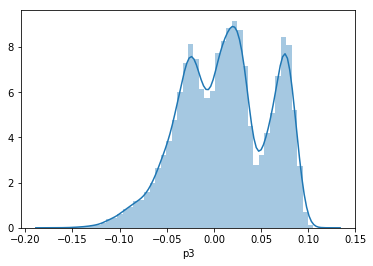

In [273]:
ax = sns.distplot(train_y)

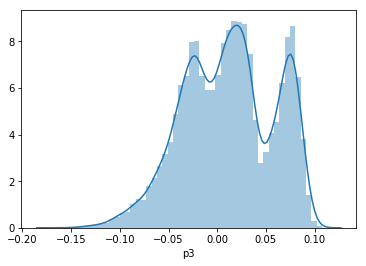

In [274]:
ax = sns.distplot(valid_y)

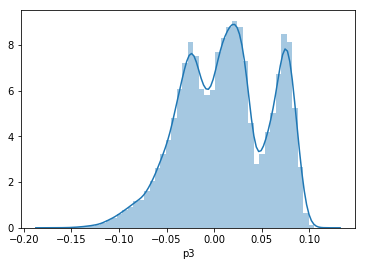

In [279]:
# 所有的label，包括train和val
ax = sns.distplot(y_train.iloc[:,2])